# Predicting Ideal System Scheduled Hours to Maximize Sales
### AIC Reflexis Systems, Apogee 2019

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import datetime
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, K, Reshape, LSTM, CuDNNLSTM
from keras.utils import np_utils
from keras.optimizers import *
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from keras.losses import *
from sklearn.preprocessing import LabelEncoder, minmax_scale, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras import backend as K
import sklearn
import os
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['BITS AIC 2019 - Reflexis Raw Dataset.csv', 'Store Attributes - Store Attributes.csv']


## Import Dataset
We first import the dataset. If using on a local machine or a fork, please change the file location in pd.read_csv().

In [2]:
#Import Dataset
df = pd.read_csv('../input/BITS AIC 2019 - Reflexis Raw Dataset.csv')
df['DATE'] = pd.to_datetime(df['DATE']) #Convert date strings to datetime format
df = df.set_index('DATE') #Index by Date
df.head()

,STORE,TRAFFIC_ACTUAL,TRANSACTIONS_ACTUAL,SALES_ACTUAL,MANAGER_SCHED_HOURS,SYSTEM_SCHED_HOURS
DATE,,,,,,
2016-01-31,203,180,37,2243.07,26.00,20.50
2016-02-01,203,49,22,424.50,28.50,29.75
2016-02-02,203,85,20,878.20,31.50,25.50
2016-02-03,203,84,25,937.80,25.50,27.50
2016-02-04,203,69,13,572.70,25.75,27.25


## Clean Dataset
We remove rows with missing values, to make sure that we are making predictions only for present values.

In [3]:
#Cleaning Dataset
df=df.dropna() #Drop missing values
df.head()

,STORE,TRAFFIC_ACTUAL,TRANSACTIONS_ACTUAL,SALES_ACTUAL,MANAGER_SCHED_HOURS,SYSTEM_SCHED_HOURS
DATE,,,,,,
2016-01-31,203,180,37,2243.07,26.00,20.50
2016-02-01,203,49,22,424.50,28.50,29.75
2016-02-02,203,85,20,878.20,31.50,25.50
2016-02-03,203,84,25,937.80,25.50,27.50
2016-02-04,203,69,13,572.70,25.75,27.25


## Exploratory Data Analysis
We see what the maximum value of our target column is, as well as the size of the dataset, after cleaning,

In [4]:
#Exploratory Data Analysis
print('Max sales = ', df['SALES_ACTUAL'].max()) 
print('Number of records =', len(df))

Max sales =  113805.47
Number of records = 121062


## Scaling sales values
We make an important assumption here - the sales values in the future will not go over the maximum already reached, or dip below the minimum already attained. Since we have no other information available to us, we have no better way of limiting the rescaling the sales values. We use a range of -1 to 1 because that is the output range of *tanh*, the function we intend to use as activation for our output (Reasoning for the usage of *tanh* is explained in the model section).

In [5]:
#Scaling Actual Sales values
df1 = df.groupby('STORE') #Group data by store
_temp = []
scalar = MinMaxScaler(feature_range=(-1,1))
for store_no, store_data in df1:
    data = df1.get_group(store_no).copy()    
    data['SALES_NORM'] = scalar.fit_transform(data['SALES_ACTUAL'].values.reshape(-1,1)) #Scaled sales between (-1,1)
    for i in data['SALES_NORM'].values:
        _temp.append(i)
df['SALES_NORM'] = _temp 
df1 = df.groupby('STORE') #Store grouped dataset separately 
df

,STORE,TRAFFIC_ACTUAL,TRANSACTIONS_ACTUAL,SALES_ACTUAL,MANAGER_SCHED_HOURS,SYSTEM_SCHED_HOURS,SALES_NORM
DATE,,,,,,,
2016-01-31,203,180,37,2243.07,26.00,20.50,-0.578366
2016-02-01,203,49,22,424.50,28.50,29.75,-0.888607
2016-02-02,203,85,20,878.20,31.50,25.50,-0.811208
2016-02-03,203,84,25,937.80,25.50,27.50,-0.801040
2016-02-04,203,69,13,572.70,25.75,27.25,-0.863325
2016-02-05,203,53,8,384.50,30.25,31.50,-0.895431
2016-02-06,203,248,43,2110.45,33.00,39.75,-0.600990
2016-02-07,203,147,37,2195.30,20.00,21.50,-0.586515
2016-02-08,203,8,0,0.00,24.50,23.25,-0.961026


## Helper functions
These functions help in visual representation of the loss values as they change with more and more training.

In [6]:
# Helper Functions for Graph Generation
class MetricsCheckpoint(Callback):
    # Callback that saves metrics after each epoch
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
        
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

#Plots RMSE
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['loss'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.sqrt(scalar.inverse_transform(np.array(metrics[k]).reshape(-1,1)).ravel()).tolist() #Restructuring data
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train') #line plot of of metrics or loss
        x = np.argmin(l)
        y = float(l[x])
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b') #Scatter plot of maxima
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('RMSE')
    plt.savefig('./RMSE_curve.png')

#Plot Loss    
def plot_learning_curve(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

## Model
We use the Root Mean Squared Error (RMSE) as our loss function. Then, we define our model creation function that takes the grouped dataset, the store number for which we want to generate a model, and the number of epochs for which we wish to train the model, and returned a trained model as output.<br>
We have set the batch size to 8, since we have nearly 800 data points and our experimentation showed that the testing losses come closest to converging on this value. We split the data into training and testing sets around the split date of 2018-02-01, which gives the training set 2 years of data. This is the minimum required to detect seasonal patterns, but leads to the testing set containing only 24 data points. We believe that having more data would let this model return better predictions.<br>
The model is defined, containing 3 layers of 64 LSTM cells each. The layers are bidirectional, so that they can use both past and future data for context. A final Dense layer with the tanh activation function is added, to generate a predicted output. The tanh function is used because it returns the best results for numerical prediction, and converting the problem into a categorical one isn't really an option due to the large number of values that 'SALES_ACTUAL' can have. After the model is trained and evaluated, the graphs of loss over time are displayed.

In [7]:
#RMSE Calculation function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#Neural Network
def f1(dfin, store_no, epochs):
    #predict sales given date, store number, system scheduled hours and manager scheduled hours
    while True:
        data = dfin.get_group(store_no)
        batch_size = 8
        scalar.fit(data['SALES_ACTUAL'].values.reshape(-1,1))
        split_date = '2018-02-01'
        X_train, Y_train, X_test, Y_test = data[data.index < split_date][['STORE','MANAGER_SCHED_HOURS','SYSTEM_SCHED_HOURS']], data[data.index < split_date]['SALES_NORM'], data[data.index>= split_date][['STORE','MANAGER_SCHED_HOURS','SYSTEM_SCHED_HOURS']], data[data.index >= split_date]['SALES_NORM']
        X_train = X_train.values.reshape(X_train.shape[0],1,X_train.shape[1])
        X_test = X_test.values.reshape(X_test.shape[0],1,X_test.shape[1])
        input_shape = (1,X_test.shape[2])
        num_classes = 1
        model = Sequential()
        model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True, input_shape=input_shape)))
        model.add(Dropout(0.25))
        model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
        model.add(Dropout(0.25))
        model.add(Bidirectional(CuDNNLSTM(64)))
        model.add(Dropout(0.25))
        model.add(Dense(num_classes, activation='tanh'))
        model.compile(loss=root_mean_squared_error, optimizer = Adam(lr=0.01), metrics=[root_mean_squared_error])
        history = model.fit(X_train, Y_train.values, epochs = epochs, steps_per_epoch=int(len(X_train) / batch_size), validation_data=(X_test, Y_test.values), validation_steps=max(int(len(X_test)/batch_size),1), callbacks = [MetricsCheckpoint('logs')])
        if np.inf not in history.history['loss']:
            score = model.evaluate(X_test, Y_test.values)
            plotKerasLearningCurve()
            plt.show()  
            plot_learning_curve(history)
            plt.show()
            return model

## Generating Model
A model is generated for store 203, trained for 50 epochs. As the graphs show, the testing loss does not coverge. Further experimentation with more epochs also leads to the same result.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 732 samples, validate on 24 samples
Epoch 1/50
91/91 [==============================] - 7s 73ms/step - loss: 0.1520 - root_mean_squared_error: 0.1520 - val_loss: 0.0729 - val_root_mean_squared_error: 0.0729
Epoch 2/50
91/91 [==============================] - 1s 8ms/step - loss: 0.1181 - root_mean_squared_error: 0.1181 - val_loss: 0.0748 - val_root_mean_squared_error: 0.0748
Epoch 3/50
91/91 [==============================] - 1s 8ms/step - loss: 0.1156 - root_mean_squared_error: 0.1156 - val_loss: 0.1117 - val_root_mean_squared_error: 0.1117
Epoch 4/50
91/91 [==============================] - 1s 8ms/step - loss: 0.1137 - root_mean_squared_error: 0.1137 - val_loss: 0.1001 - val_root_mean_squared_error: 0.1001
Epoch 5/50
91/91 [=====================

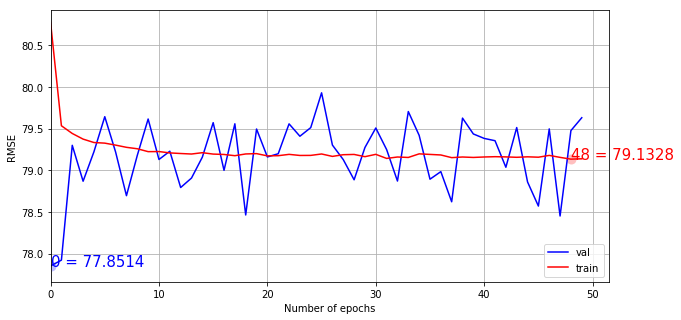

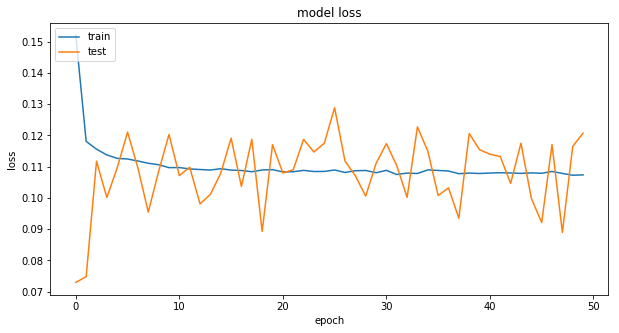

In [8]:
#Generating model for store 203
lstm_model = f1(df1, 203, 50)

## Maximizing Sales
Since the model generated does not have coverging testing loss, we decided to iterate over all possible values of 'SYSTEM_SCHED_HOURS' to get the maximum. Another factor in this decision was the fact that the values of 'SYSTEM_SCHED_HOURS' and 'MANAGER_SCHED_HOURS' change in intervals of 0.25 - thus, the number of possible values is very low. The maximum possible is 24*7*(1/0.25)=672, for 24 hour workdays, 7 days a week, and increments of 0.25. This iterative process will always give the global maximum.<br>
Predictions are made by setting the hypothetical input to have equal values of 'SYSTEM_SCHED_HOURS' and 'MANAGER_SCHED_HOURS' to find the optimum. We have used 12 hour workdays, for 7 days a week.<br>
Once we obtain the value of 'SYSTEM_SCHED_HOURS' that gives maximum possible sales, we iterate over all possible values of 'MANAGER_SCHED_HOURS' to see how changes in this variable affect the sales. A graph is generated for this, and the maximum is found.

In [9]:
#Iterating over all possible inputs to get variation of sales.
store_no = 203
ls1=[]
ls2=[]
dfstore = df1.get_group(store_no)
scalar.fit(dfstore['SALES_ACTUAL'].values.reshape(-1,1))
wpd = 12
for i in range(wpd*7*4+1):
    x_in = np.array([[store_no, float(i)/4.0, float(i)/4.0]])
    x_in = x_in.reshape(x_in.shape[0], 1, x_in.shape[1])
    ls1.append(scalar.inverse_transform(lstm_model.predict(x_in)).tolist()[0][0])

for j in range(wpd*7*4+1):
    x_in = np.array([[store_no, float(j)/4.0, float(ls1.index(max(ls1)))/4.0]])
    x_in = x_in.reshape(x_in.shape[0], 1, x_in.shape[1])
    ls2.append(scalar.inverse_transform(lstm_model.predict(x_in)).tolist()[0][0])
xrange = np.arange(0,wpd*7+0.25,0.25)        


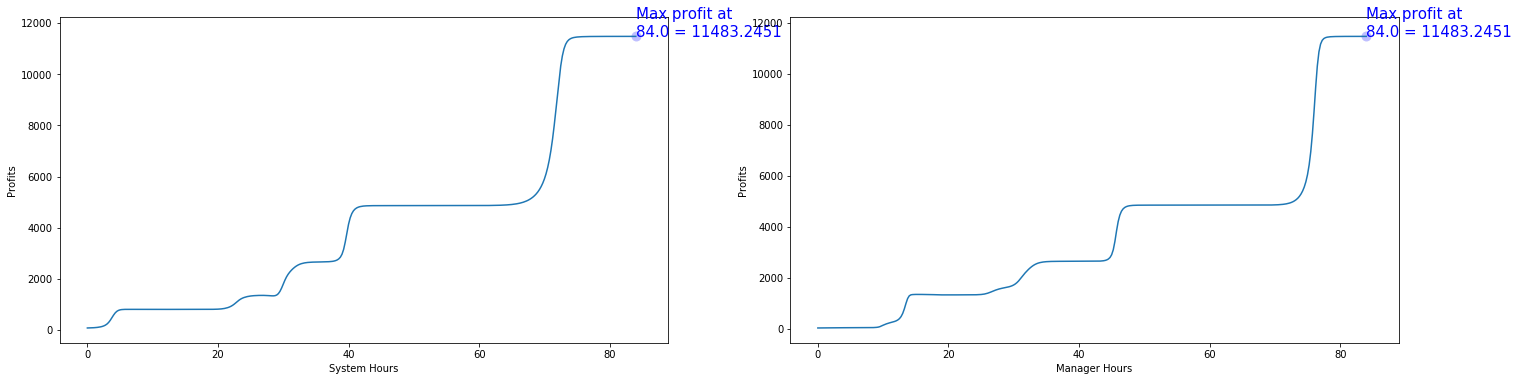

<Figure size 432x288 with 0 Axes>

In [10]:
#Plot predicted values of sales 
plt.figure(figsize = (24,6))
plt.subplot(1,2,1)
plt.plot(xrange, ls1)
plt.xlabel('System Hours')
plt.ylabel('Profits')
x = np.argmax(ls1)
y = ls1[x]
plt.scatter(x/4, y, lw = 0, alpha = 0.25, s = 100, c = 'b')
plt.text( x/4, y, 'Max profit at\n{} = {:.4f}'.format(x/4,y), size='15', color='b')
plt.subplot(1,2,2)
plt.plot(xrange, ls2)
plt.xlabel('Manager Hours')
plt.ylabel('Profits')
x = np.argmax(ls2)
y = ls2[x]
plt.scatter(x/4,y, lw=0, alpha=0.25, s=100, c='b')
plt.text(x/4, y, 'Max profit at\n{} = {:.4f}'.format(x/4,y), size='15', color='b')
plt.show()
plt.savefig('./optimum_hours.png')